In [1]:
from __future__ import division
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, roc_curve, auc, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, StratifiedKFold
from sklearn.model_selection import ShuffleSplit, learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import KNeighborsRegressor

import sys
sys.path.insert(0, '/Users/Naekid/Desktop/capstone-DSI-5/ebay-price-predictor/data-analysis/utilities/')
from plot_learning_curve import plot_learning_curve
from clean_text import clean_text

pd.set_option('display.max_columns', 60)

Import data

In [2]:
auctions = pd.read_pickle('./pickles/auctions.p')
concurrent_similar_median_start_price_series = pd.read_pickle('./feature-engineering-concurrent-similar-median-start-price/pickles/auctions_median_start_price_series.p')
concurrent_similar_median_start_price_series.name = 'concurrent_similar_median_start_price'

In [3]:
# Count NaN values
print 'Total Values:',concurrent_similar_median_start_price_series.shape[0]
print 'Non NaN Values:',concurrent_similar_median_start_price_series.count()
print 'NaN Values:',concurrent_similar_median_start_price_series.shape[0] - concurrent_similar_median_start_price_series.count()

Total Values: 29961
Non NaN Values: 22376
NaN Values: 7585


Impute missing values

In [4]:
# Replace missing concurrent median start prices with the median overall start price
concurrent_similar_median_start_price_series[concurrent_similar_median_start_price_series.isnull()] = np.median(auctions['startPrice'])

Extract Features

In [7]:
# Use startPrice, title (vectorized), conditionDisplayName (one-hot-encoded)
auction_condition_dummies = pd.get_dummies(data=auctions['condition.conditionDisplayName'])

start_price_series = auctions['startPrice']

titles = auctions['title']

sold = auctions['sold_state']

condition_combined = auctions['conditionCombined']

end_price = auctions['endPrice']

start_time_series = auctions['listingInfo.startTime']

end_time_series = auctions['listingInfo.endTime']

Clean text

In [54]:
clean_titles = []
for i,title in enumerate(titles.values):
    if (i+1)%5000==0:
        print 'cleaning #{} out of {} documents'.format(i+1,len(condition_combined))
    clean_titles.append(clean_text(title))

cleaning #5000 out of 29961 documents
cleaning #10000 out of 29961 documents
cleaning #15000 out of 29961 documents
cleaning #20000 out of 29961 documents
cleaning #25000 out of 29961 documents


In [55]:
clean_conditions = []
for i,cond in enumerate(condition_combined):
    if (i+1)%5000==0:
        print 'cleaning #{} out of {} documents'.format(i+1,len(condition_combined))
    clean_conditions.append(clean_text(cond))

cleaning #5000 out of 29961 documents
cleaning #10000 out of 29961 documents
cleaning #15000 out of 29961 documents
cleaning #20000 out of 29961 documents
cleaning #25000 out of 29961 documents


In [56]:
vectorizer = CountVectorizer(ngram_range = (1,2),
                             min_df=5,
                             analyzer='word',
                             stop_words=None,
                             max_features=10000,
                            )

titles_matrix = vectorizer.fit_transform(clean_titles)

import operator
# print sorted(vectorizer.vocabulary_.items(), key=operator.itemgetter(1), reverse=True)[:5]

titles_df = pd.DataFrame(titles_matrix.todense(), columns=vectorizer.vocabulary_.keys())

In [57]:
vectorizer = CountVectorizer(ngram_range = (1,2),
                             min_df=30,
                             analyzer='word',
                             stop_words=None,
                             max_features=5000,
                            )

conditions_matrix = vectorizer.fit_transform(clean_conditions)

import operator
# print 'most common condition grams:',sorted(vectorizer.vocabulary_.items(), key=operator.itemgetter(1), reverse=True)[:5]
# print 'least common condition grams:',sorted(vectorizer.vocabulary_.items(), key=operator.itemgetter(1), reverse=False)[:5]

conditions_df = pd.DataFrame(conditions_matrix.todense(), columns=vectorizer.vocabulary_.keys())

In [58]:
del clean_titles
del clean_conditions
del conditions_matrix
del titles_matrix

## Create Processed DataFrame

**Create processed feature dataframe**

In [20]:
data_frames_to_keep = [\
#                         titles_df,\
#                        conditions_df,\
#                        auction_condition_dummies,\
                       concurrent_similar_median_start_price_series,\
                       start_price_series,\
                       end_price,\
                       sold]


df_classification = pd.concat(data_frames_to_keep, axis=1)

In [60]:
for dataframe in data_frames_to_keep:
    del dataframe

** Train Test Split **

In [84]:
df_classification.head(2)

,z990 12,excellent cond,lumix digital,grip charger,medium format,270,275,kodak,af nikon,body read,cmos smart,package deal,card case,lens free,batteries strap,e6,slt a33,slt a35,zoom lense,fe fe,elph 170,fujifilm pro1,tz25,body working,12 megapixel,titanium,zoom mega,fuji fine,dsc f707,travel,...,come,working camera,rubber,condition shutter,sony,functioning,bundle,photos hassle,scratches dents,cleaned,condition low,please read,shutter actuations,store returns,dent,operational,know,repair,warranty,ex,little use,For parts or not working,Manufacturer refurbished,New,New other (see details),Seller refurbished,Used,concurrent_similar_median_start_price,startPrice,sold_state
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,92.5,399.0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,92.5,300.0,1


In [75]:
X_class = df_classification.ix[:, :-1].values
y_class = df_classification.ix[:, -1].values

X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X_class, y_class, random_state=42, test_size=0.2)

** Model **

In [76]:
rfc = RandomForestClassifier(n_estimators=100, n_jobs=-1)

rfc.fit(X_train_class, y_train_class)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [63]:
print 'top 5 features:'
feature_importances = sorted(zip(df_classification.columns.tolist()[:-1], rfc.feature_importances_), key=lambda x: x[1], reverse=True)
sorted(zip(df_classification.columns.tolist()[:-1], rfc.feature_importances_), key=lambda x: x[1], reverse=True)[:5]

top 5 features:


[('startPrice', 0.091041724275354508),
 ('concurrent_similar_median_start_price', 0.072779250151591424),
 (u'scratches body', 0.0065584151677305557),
 (u'50mm prime', 0.0048426325250845821),
 (u'255', 0.0041375394373774389)]

# Score Model

Baseline 

In [71]:
from sklearn.metrics import accuracy_score
# calculate baseline
y_true = y_train_class
y_pred = np.ones(y_true.shape[0])
print 'Baseline accuracy:',accuracy_score(y_true, y_pred)

Baseline accuracy: 0.853763351135


Cross val score

In [69]:
# scores = cross_val_score(estimator=RandomForestClassifier(n_estimators=100, n_jobs=-1), X=X_class, y=y_class, scoring='accuracy',cv=3, n_jobs=-1)
# print np.mean(scores)

In [78]:
print 'Test accuracy WITHOUT csm start price:',accuracy_score(y_test_class, rfc.predict(X_test_class))

Test accuracy WITHOUT csm start price: 0.904054730519


In [79]:
print 'Test accuracy WITH csm start price:',accuracy_score(y_test_class, rfc.predict(X_test_class))

Test accuracy WITH csm start price: 0.904054730519


### Explore why concurrent similar start price is not helping model.

Plotting csm start price vs end price

Based on the numbers, the CSM start price variance is less than the overall auction start price.

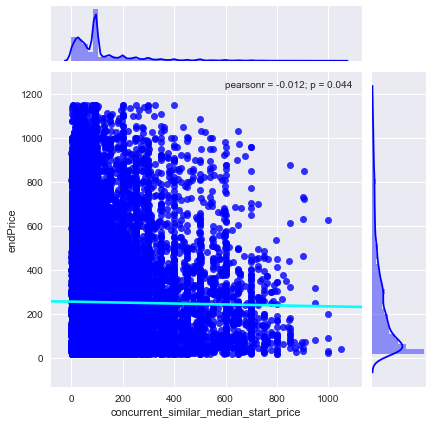

In [163]:
sns.jointplot(x=concurrent_similar_median_start_price_series, y=end_price, kind='reg', ci=5, color='b',joint_kws={'line_kws':{'color':'cyan'}})
# g.title('CSM Start Price vs End Price')
# g.xlabel('CSM Start Price')
# plt.ylabel('End Price')

(0, 400)

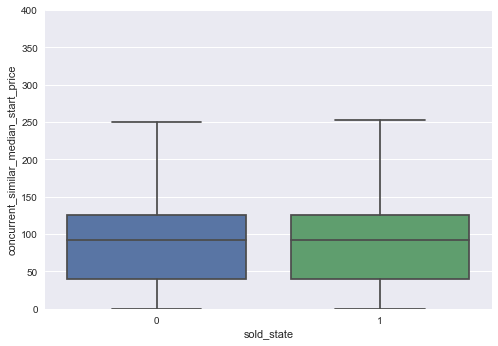

In [19]:
sns.boxplot(x=df_classification['sold_state'], 
            y=df_classification['concurrent_similar_median_start_price'],
           fliersize=0)d

plt.ylim(0, 400)

The results of our modeling and the plots above show that the start price of similar, concurrent listings don't affect the end price. 
<br><br>
The question is why is this? Are people considering the start price of similar, concurrent listings when they post their items? More specifically, is the start price of similar, concurrent listings correlated with the start price for a paritcular listing?

In [111]:
non_null_csm_start_price_subset = df_classification[df_classification['concurrent_similar_median_start_price']!=92.5]

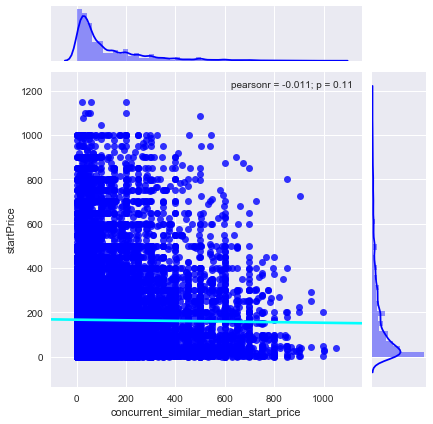

In [165]:
sns.jointplot(x=non_null_csm_start_price_subset['concurrent_similar_median_start_price'],\
              y=non_null_csm_start_price_subset['startPrice'],\
              kind='reg', ci=5, color='b',joint_kws={'line_kws':{'color':'cyan'}})

No it doesn't seem that the CSM start price has an affect on start price. 

oes the distribution of CSM start prices have a tighter variance than the distribution of ALL start prices? In other words, is there less randomness in the CSM start prices?

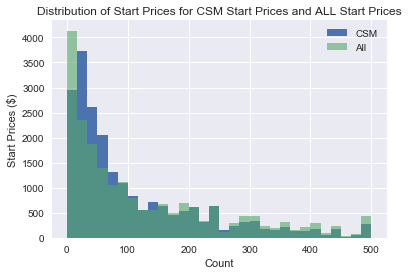

In [140]:
# range=(-50, 50)
bins=30
max_range = 500
plt.hist(non_null_csm_start_price_subset['concurrent_similar_median_start_price'].values, bins=bins, range=(0,max_range), label='CSM');
plt.hist(non_null_csm_start_price_subset['startPrice'].values, bins=bins, range=(0,max_range), alpha=0.6, label='All');
plt.ylabel('Start Prices ($)')
plt.xlabel('Count')
plt.title('Distribution of Start Prices for CSM Start Prices and ALL Start Prices')
plt.legend()

**Explore variance of start prices for CSM and ALL**
<br>Take the log to get normal distributions

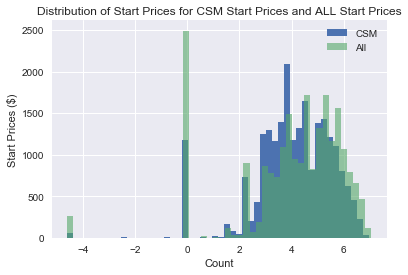

In [146]:
bins=50
plt.hist(np.log(non_null_csm_start_price_subset['concurrent_similar_median_start_price'].values), bins=bins, label='CSM');
plt.hist(np.log(non_null_csm_start_price_subset['startPrice'].values), bins=bins, alpha=0.6, label='All');
plt.ylabel('Start Prices ($)')
plt.xlabel('Count')
plt.title('Distribution of Start Prices for CSM Start Prices and ALL Start Prices')
plt.legend()

To quantify with numbers:

In [170]:
print 'Auctions Start Price Max:', np.max(auctions['startPrice'].values)
print 'Auctions Start Price Min:', np.min(auctions['startPrice'].values)
print 'Auctions Start Price Variance:', np.var(auctions['startPrice'].values)
print 'Auctions Start Price Std Dev:', np.std(auctions['startPrice'].values)

Auctions Start Price Max: 1150.0
Auctions Start Price Min: 0.01
Auctions Start Price Variance: 37277.1299753
Auctions Start Price Std Dev: 193.07286183


In [171]:
print 'CSM Start Price Max:', np.max(non_null_csm_start_price_subset['concurrent_similar_median_start_price'].values)
print 'CSM Start Price Min:', np.min(non_null_csm_start_price_subset['concurrent_similar_median_start_price'].values)
print 'CSM Start Price Variance:', np.var(non_null_csm_start_price_subset['concurrent_similar_median_start_price'].values)
print 'CSM Start Price Std Dev:', np.std(non_null_csm_start_price_subset['concurrent_similar_median_start_price'].values)

CSM Start Price Max: 1049.5
CSM Start Price Min: 0.01
CSM Start Price Variance: 22369.7277446
CSM Start Price Std Dev: 149.565128772


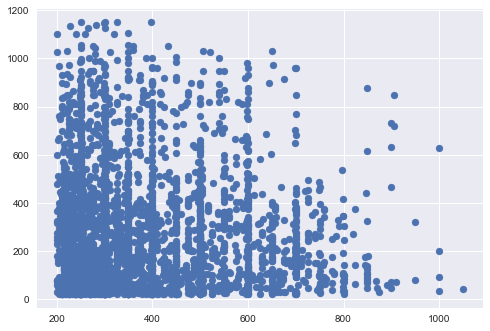

In [28]:
df_sold = df_classification.loc[(df_classification.sold_state == 1) &
                                (df_classification['concurrent_similar_median_start_price'] > 200)
                               ]

plt.scatter(df_sold['concurrent_similar_median_start_price'], df_sold['endPrice'])

**Conclusion**
<br>
There doesn't seem to be less randomness in the concurrent similar median start prices. 

In [25]:
df_classification[df_classification['concurrent_similar_median_start_price'] > 39.95]

,concurrent_similar_median_start_price,startPrice,endPrice,sold_state
0,92.50,399.00,399.00,0
1,92.50,300.00,369.00,1
2,92.50,349.99,385.00,1
3,92.50,0.99,387.00,1
4,92.50,380.00,380.00,0
5,92.50,370.00,370.00,1
6,92.50,378.00,378.00,1
7,92.50,382.00,382.00,0
8,92.50,150.00,394.00,1
9,92.50,0.01,377.00,1
